In [1]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [3]:
print("length of dataset in characters: ", len(text))
print(text[:30])

length of dataset in characters:  1115394
First Citizen:
Before we proce


In [5]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [8]:
stoi = {ch:i for i, ch in enumerate(chars)}
itos = {i:ch for ch, i in stoi.items()}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

print(encode('hi: there'))
print(decode(encode('hi: there')))

[46, 47, 10, 1, 58, 46, 43, 56, 43]
hi: there


In [67]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100])

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


In [10]:
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

In [11]:
block_size = 8
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [12]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


In [13]:
torch.manual_seed(1337)
batch_size = 4
block_size = 8

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs')
print(xb.shape)
print(xb)
print('targets')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size):
    for t in range(block_size):
        context = xb[b, :t+1]
        target = yb[b, t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53, 

In [64]:
import torch
import torch.nn as nn
from torch.nn import functional as F 
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        #idx and targets are both (B, T) tensor of integers
        logits = self.token_embedding_table(idx)  #(B, T, C) batch, block, channel or vocab

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            # print("logits shape", logits.shape)
            # print("target shape", targets.shape)
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            # print("after logits shape", logits.shape)
            # print("after target shape", targets.shape)

            loss = F.cross_entropy(logits, targets)
        return logits, loss
        
    def generate(self, idx, max_new_tokens):
    # idx is (B, T) array of indices in the current context
        for i in range(max_new_tokens):
            # get the predicion
            logits, loss = self(idx)  #[1, 1, 65]
            # focus only on the last time step
            logits1 = logits[:, -1, :] #becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits1, dim=-1)  #(B, C)
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            idx = torch.cat ((idx, idx_next), dim = 1)  #(B, T+1)
            # print("logits", logits.shape)
            # print("logits1", logits1)
            # print("probs", probs)
            # print("idx_next", idx_next)
        return idx

    
    

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)


print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))




torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)

Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


In [65]:
# create a pytorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

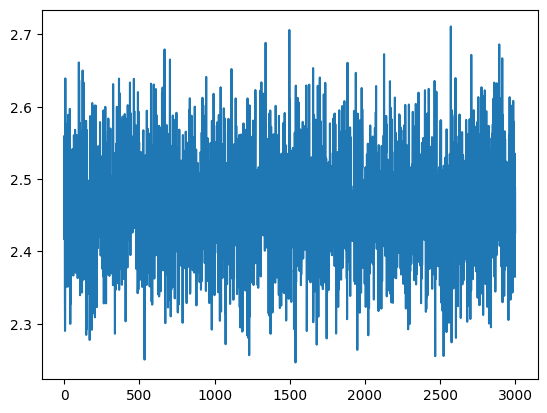

In [80]:
batch_size = 32
lossa = []
for steps in range(3000):

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    lossa.append(loss)

plt.plot(torch.tensor(lossa).detach().numpy())

In [81]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=400)[0].tolist()))


ILKI d h, myoras eryo, urers ourt al! bonto Bimer doffrttandengher'PHO:

ING fotomy, INooly.
Mis.
T:
Torouetama t tevorenberdhenge bl
Fir.
Y:
the aow GHaslesome.
Piowisesethefow Habunds, d t carnpeqGh ien:
TIVjougoue h ayowie g t
h dereng h alevigr hand fes, prthe iad ts at br myos an moup mandse Gedorlom acofa ntossen IOPhe'Pon t brdoo en he nshowinacinbewiquruniru we y mablir g bleldiced mu sshe
